# Supervised Learning Use Case: Predicting Housing Prices

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn 
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn import linear_model
from sklearn import preprocessing
np.set_printoptions(suppress=True)
from IPython.display import display
pd.options.display.float_format = '{:.3f}'.format

/Users/fnkyazn/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


#### Referenced Resources: 
1. Categorical encoding: http://pbpython.com/categorical-encoding.html


## Read in Data

In [2]:
df = pd.read_csv('Melbourne_housing_FULL.csv')

In [3]:
len(df)

34857

At first glance, it looksl ike we have a pretty diverse dataset with a mixture of data types. 

In [4]:
# Preview Data
df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,nan,SS,Jellis,3/09/2016,2.500,3067.000,...,1.000,1.000,126.000,nan,nan,Yarra City Council,-37.801,144.996,Northern Metropolitan,4019.000
1,Abbotsford,85 Turner St,2,h,1480000.000,S,Biggin,3/12/2016,2.500,3067.000,...,1.000,1.000,202.000,nan,nan,Yarra City Council,-37.800,144.998,Northern Metropolitan,4019.000
2,Abbotsford,25 Bloomburg St,2,h,1035000.000,S,Biggin,4/02/2016,2.500,3067.000,...,1.000,0.000,156.000,79.000,1900.000,Yarra City Council,-37.808,144.993,Northern Metropolitan,4019.000
3,Abbotsford,18/659 Victoria St,3,u,nan,VB,Rounds,4/02/2016,2.500,3067.000,...,2.000,1.000,0.000,nan,nan,Yarra City Council,-37.811,145.012,Northern Metropolitan,4019.000
4,Abbotsford,5 Charles St,3,h,1465000.000,SP,Biggin,4/03/2017,2.500,3067.000,...,2.000,0.000,134.000,150.000,1900.000,Yarra City Council,-37.809,144.994,Northern Metropolitan,4019.000


There are quite a few attributes with missing values, for the purpose of our analysis we'll retain observations that contain variables that inuititively seem related to housing price (e.g. date built, number of bathrooms etc.)

In [5]:
# Evaluate where missing values are
df.isnull().sum()

Suburb               0
Address              0
Rooms                0
Type                 0
Price             7610
Method               0
SellerG              0
Date                 0
Distance             1
Postcode             1
Bedroom2          8217
Bathroom          8226
Car               8728
Landsize         11810
BuildingArea     21115
YearBuilt        19306
CouncilArea          3
Lattitude         7976
Longtitude        7976
Regionname           3
Propertycount        3
dtype: int64

In [6]:
# Review missing columns with significant missing values
df.drop(['Lattitude','Longtitude','Address','SellerG'],axis=1,inplace=True)

In [7]:
df = df[np.isfinite(df['Price'])]

In [8]:
# Drop any remaining rows with missing values
df = df.dropna()

After dropping irrelevant variables and retaining observations with seemingly meaningful attributes, while we're left with a data set that's much smaller relative to the data set's original size, we're sitll left with plenty of observations -- enough to suffice for our modeling exercise. 

In [9]:
# Evaluate data set size
len(df)

8895

## Examine Data

For the date attribute, it's certainly plausible that the month and year the property was listed may affect property value. The day of week the property was listed, however, probably isn't too relevant for our analysis. Let's retain just the month and year features of the listing date. 

In [10]:
# Date feature may be useful in the model, convert data attribute using Datetimeindex
df["Date"] = pd.to_datetime(df["Date"])
df["Month"] = pd.DatetimeIndex(df["Date"]).month
df["Year"] = pd.DatetimeIndex(df["Date"]).year
df.drop(["Date"],axis=1,inplace=True)
df.head()

,Suburb,Rooms,Type,Price,Method,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Regionname,Propertycount,Month,Year
2,Abbotsford,2,h,1035000.000,S,2.500,3067.000,2.000,1.000,0.000,156.000,79.000,1900.000,Yarra City Council,Northern Metropolitan,4019.000,4,2016
4,Abbotsford,3,h,1465000.000,SP,2.500,3067.000,3.000,2.000,0.000,134.000,150.000,1900.000,Yarra City Council,Northern Metropolitan,4019.000,4,2017
6,Abbotsford,4,h,1600000.000,VB,2.500,3067.000,3.000,1.000,2.000,120.000,142.000,2014.000,Yarra City Council,Northern Metropolitan,4019.000,4,2016
11,Abbotsford,3,h,1876000.000,S,2.500,3067.000,4.000,2.000,0.000,245.000,210.000,1910.000,Yarra City Council,Northern Metropolitan,4019.000,7,2016
14,Abbotsford,2,h,1636000.000,S,2.500,3067.000,2.000,1.000,2.000,256.000,107.000,1890.000,Yarra City Council,Northern Metropolitan,4019.000,8,2016


While suburb and council area may be meaningful attributes, they contain too many unique values for one hot encoding. For the time being, we'll omit these features and revisit how to handle them later should our model not perform as well as we would expect. 

In [11]:
# Drop categorical features with significant unique values
df.drop(['Suburb','CouncilArea'],axis=1,inplace=True)

In [12]:
# Convert remaining categorical values to numeric
df = pd.get_dummies(df,columns=["Type","Method","Regionname"],prefix=["type","method","region"])

In [13]:
df.head()

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,...,method_SP,method_VB,region_Eastern Metropolitan,region_Eastern Victoria,region_Northern Metropolitan,region_Northern Victoria,region_South-Eastern Metropolitan,region_Southern Metropolitan,region_Western Metropolitan,region_Western Victoria
2,2,1035000.000,2.500,3067.000,2.000,1.000,0.000,156.000,79.000,1900.000,...,0,0,0,0,1,0,0,0,0,0
4,3,1465000.000,2.500,3067.000,3.000,2.000,0.000,134.000,150.000,1900.000,...,1,0,0,0,1,0,0,0,0,0
6,4,1600000.000,2.500,3067.000,3.000,1.000,2.000,120.000,142.000,2014.000,...,0,1,0,0,1,0,0,0,0,0
11,3,1876000.000,2.500,3067.000,4.000,2.000,0.000,245.000,210.000,1910.000,...,0,0,0,0,1,0,0,0,0,0
14,2,1636000.000,2.500,3067.000,2.000,1.000,2.000,256.000,107.000,1890.000,...,0,0,0,0,1,0,0,0,0,0


There are some attributes that are correlated with pricing and there's some mild to moderate multicollineraity. The presence of clearly relevant variables will be good in the context of modeling, however we'll need to be weary of multicollinearity when interpreting the models. 

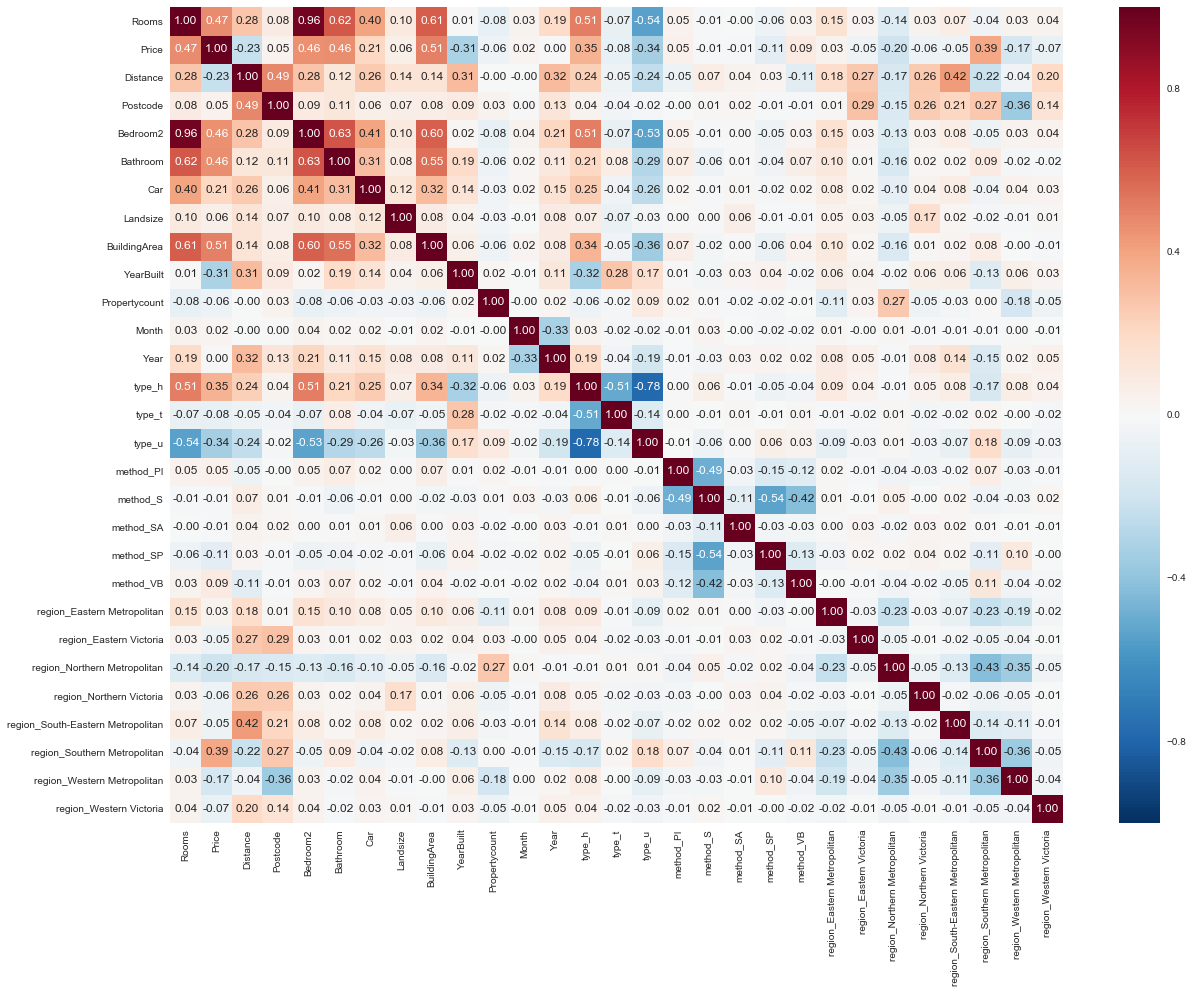

In [14]:
plt.figure(figsize=(20,15))
sns.heatmap(df.corr(),annot=True,fmt=".2f")

In [15]:
from scipy.stats.mstats import winsorize

The median housing price sits at $900,000 AUD which translates roughly to $660,800 USD. 

The median housing price: $ 900000.0 


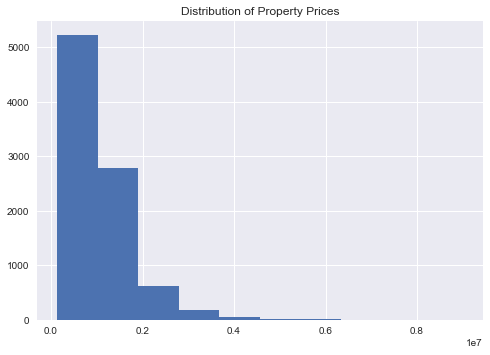

In [16]:
plt.hist(df['Price'])
plt.title('Distribution of Property Prices')
print('The median housing price: $',np.median(df['Price']),'')

## Feature Selection

In [17]:
# Prepare attributes and target variables
X = df.drop('Price',axis=1)
y = df['Price']

### PCA

Most of the variance is explained in the first component, for our modeling exercise we'll retain just the first component. 

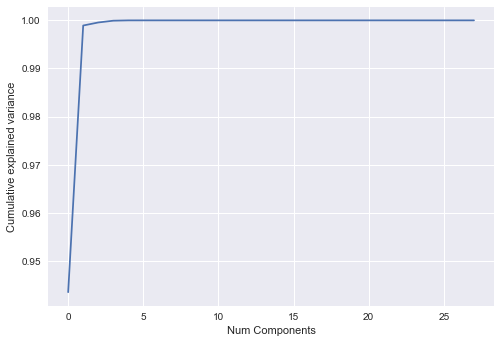

In [18]:
from sklearn.decomposition import PCA
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Num Components')
plt.ylabel('Cumulative explained variance')

In [19]:
pca.explained_variance_ratio_

array([ 0.9434853 ,  0.05544371,  0.00062969,  0.00037216,  0.00006695,
        0.00000155,  0.00000043,  0.00000006,  0.00000003,  0.00000002,
        0.00000002,  0.00000001,  0.00000001,  0.00000001,  0.00000001,
        0.00000001,  0.00000001,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ])

In [20]:
components = 1

## Modeling

In [21]:
# Prepare attributes and target variables
X = df.drop('Price',axis=1)
y = df['Price']

In [22]:
len(y)

8895

In [23]:
# Split dataset into training and testing subsets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, random_state=12)

In [24]:
# Establish number of features to test each time during grid search
features = list(range(1,len(X.columns),3))

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import time
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

kbest = SelectKBest(mutual_info_regression)

# Construct some pipelines
pipe_lr = Pipeline([('kbest', kbest),
            ('scl', StandardScaler()),
            ('clf', LogisticRegression())])

pipe_lr_pca = Pipeline([('scl', StandardScaler()),
            ('pca', PCA(n_components=components)),
            ('clf', LogisticRegression())])

pipe_gb = Pipeline([('kbest', kbest),
            ('scl', StandardScaler()),
            ('clf', GradientBoostingRegressor())])

pipe_gb_pca = Pipeline([('scl', StandardScaler()),
            ('clf', GradientBoostingRegressor())])

pipe_knn = Pipeline([('kbest', kbest),
                    ('scl',StandardScaler()),
                    ('clf',KNeighborsRegressor())])

pipe_knn_pca = Pipeline([('scl', StandardScaler()),
            ('pca', PCA(n_components=components)),
            ('clf', KNeighborsRegressor())])

pipe_rf = Pipeline([('kbest', kbest),
            ('scl', StandardScaler()),
            ('clf', RandomForestRegressor())])

pipe_rf_pca = Pipeline([('scl', StandardScaler()),
            ('pca', PCA(n_components=components)),
            ('clf', RandomForestRegressor())])

pipe_svr = Pipeline([('kbest', kbest),
            ('scl', StandardScaler()),
            ('clf', svm.SVR())])

pipe_svr_pca = Pipeline([('scl', StandardScaler()),
            ('pca', PCA(n_components=components)),
            ('clf', svm.SVR())])

pipe_tree = Pipeline([('kbest', kbest),
            ('scl', StandardScaler()),
            ('clf', DecisionTreeRegressor())])

pipe_tree_pca = Pipeline([('scl', StandardScaler()),
            ('clf', DecisionTreeRegressor())])

# Set grid search params
param_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
param_range_fl = [1.0, 0.5, 0.1]

grid_params_lr = [{'kbest__k': features,
        'clf__penalty': ['l1', 'l2'],
        'clf__C': param_range_fl,
        'clf__solver': ['liblinear']}] 

grid_params_lr_pca = [{'clf__penalty': ['l1', 'l2'],
        'clf__C': param_range_fl,
        'clf__solver': ['liblinear']}] 


grid_params_gb = [{'kbest__k':features,
                   'clf__loss': ['ils','lad','huber','quantile'],
                   'clf__n_estimators': [100,200,300,400,500],
                   'clf__max_depth': [2,4,6,8,10]}]

grid_params_gb_pca = [{'clf__loss': ['ils','lad','huber','quantile'],
                   'clf__n_estimators': [100,200,300,400,500],
                   'clf__max_depth': [2,4,6,8,10]}]

grid_params_knn = [{
        'kbest__k': features,
        'clf__n_neighbors': [1,2,3,4,5,6,7,8,9,10], 
        'clf__weights': ['uniform','distance'],
        'clf__algorithm':['ball_tree','brute','auto','kd_tree'],
        'clf__leaf_size':[10,20,30,40,50,60,70,80,90,100]}]

grid_params_knn_pca = [{'clf__n_neighbors': [1,2,3,4,5,6,7,8,9,10], 
        'clf__weights': ['uniform','distance'],
        'clf__algorithm':['ball_tree','brute','auto','kd_tree'],
        'clf__leaf_size':[10,20,30,40,50,60,70,80,90,100]}]

grid_params_rf = [{'kbest__k': features,
        'clf__min_samples_leaf': param_range,
        'clf__max_depth': param_range,
        'clf__min_samples_split': param_range[1:]}]

grid_params_rf_pca = [{
        'clf__min_samples_leaf': param_range,
        'clf__max_depth': param_range,
        'clf__min_samples_split': param_range[1:]}]

grid_params_svr = [{'kbest__k': features,
        'clf__epsilon': [0.1,0.3,0.5,0.7,1], 
        'clf__kernel': ['linear','rbf','sigmoid','precomputed'],
        'clf__gamma': ['rbf','poly','sigmoid','auto']}]

grid_params_svr_pca = [{'clf__epsilon': [0.1,0.3,0.5,0.7,1], 
        'clf__kernel': ['linear','rbf','sigmoid','precomputed'],
        'clf__gamma': ['rbf','poly','sigmoid','auto']}]

grid_params_tree = [{'kbest__k':features}]

grid_params_tree_pca = [{}]




# Construct grid searches
jobs = -1

gs_lr = GridSearchCV(estimator=pipe_lr,
            param_grid=grid_params_lr,
            scoring='neg_mean_squared_error',
            cv=10) 

gs_lr_pca = GridSearchCV(estimator=pipe_lr_pca,
            param_grid=grid_params_lr_pca,
            scoring='neg_mean_squared_error',
            cv=10)

                      
gs_gb = GridSearchCV(estimator=pipe_gb,
            param_grid=grid_params_gb,
            scoring='neg_mean_squared_error',
            cv=10,
            n_jobs=jobs)

gs_gb_pca = GridSearchCV(estimator=pipe_gb_pca,
            param_grid=grid_params_gb_pca,
            scoring='neg_mean_squared_error',
            cv=10,
            n_jobs=jobs)

gs_knn = GridSearchCV(estimator=pipe_knn,
            param_grid=grid_params_knn,
            scoring='neg_mean_squared_error',
            cv=10,
            n_jobs=jobs)

gs_knn_pca = GridSearchCV(estimator=pipe_knn_pca,
            param_grid=grid_params_knn_pca,
            scoring='neg_mean_squared_error',
            cv=10,
            n_jobs=jobs)

gs_rf = GridSearchCV(estimator=pipe_rf,
            param_grid=grid_params_rf,
            scoring='neg_mean_squared_error',
            cv=10, 
            n_jobs=jobs)

gs_rf_pca = GridSearchCV(estimator=pipe_rf_pca,
            param_grid=grid_params_rf_pca,
            scoring='neg_mean_squared_error',
            cv=10, 
            n_jobs=jobs)

gs_svr = GridSearchCV(estimator=pipe_svr,
            param_grid=grid_params_svr,
            scoring='neg_mean_squared_error',
            cv=10,
            n_jobs=jobs)

gs_svr_pca = GridSearchCV(estimator=pipe_svr_pca,
            param_grid=grid_params_svr_pca,
            scoring='neg_mean_squared_error',
            cv=10,
            n_jobs=jobs)

gs_tree = GridSearchCV(estimator=pipe_tree,
            param_grid=grid_params_tree,
            scoring='neg_mean_squared_error',
            cv=10,
            n_jobs=jobs)

gs_tree_pca = GridSearchCV(estimator=pipe_tree_pca,
            param_grid=grid_params_tree_pca,
            scoring='neg_mean_squared_error',
            cv=10,
            n_jobs=jobs)


# List of pipelines for ease of iteration
#grids = [gs_lr, gs_lr_pca, gs_gb, gs_gb_pca, gs_knn, gs_knn_pca,
        #gs_rf, gs_rf_pca, gs_svr, gs_svr_pca, gs_tree, gs_tree_pca]
    
grids = [gs_knn]



# Dictionary of pipelines and classifier types for ease of reference
grid_dict = {0: 'Logistic Regression', 1: 'Logistic Regression w/PCA', 
        2: 'Gradient Boosting Regression', 3: 'Gradient Boosting Regression w/ PCA',
            4: 'KNN', 5:'KNN w/ PCA', 6:'Random Forest', 7:'Random Forest w/ PCA',
            8: 'Support Vector Regression', 9:'Support Vector Regression w/ PCA',
            10: 'Decision Tree', 11: 'Decision Tree w/ PCA'}
    


In [ ]:
model = []
training_mse = []
test_mse = []
mse_score = []
t = []


import timeit
from sklearn.metrics import mean_squared_error

# Fit the grid search objects
print('Performing model optimizations...')
best_acc = 0.0
best_clf = 0
best_gs = ''
for idx, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])
    model.append(grid_dict[idx])
    # Fit grid search
    start = timeit.timeit()
    gs.fit(X_train, y_train)
    stop = timeit.timeit()
    t.append(start-stop)
    # Best params
    print('Best params: %s' % gs.best_params_)
    # Best training data accuracy
    print('Best MSE: %.3f' % gs.best_score_)
    training_mse.append(gs.best_score_)
    # Predict on test data with best params
    y_pred = gs.predict(X_test)
    # Test data accuracy of model with best params
    print('Test set mse score for best params: %.3f ' % accuracy_score(y_test, y_pred))
    test_mse.append(accuracy_score(y_test, y_pred))
    # Track best (highest test accuracy) model
    if mean_squared_error(y_test, y_pred) < best_mse:
        best_mse = mean_squared_error(y_test, y_pred)
        best_gs = gs
        best_clf = idx
    mse_score.append(mean_squared_error(y_test,y_pred))
print('\nRegressor with best MSE: %s' % grid_dict[best_clf])

# Save best grid search pipeline to file
dump_file = 'best_gs_pipeline.pkl'
joblib.dump(best_gs, dump_file, compress=1)
print('\nSaved %s grid search pipeline to file: %s' % (grid_dict[best_clf], dump_file))

Performing model optimizations...

Estimator: Logistic Regression


In [ ]:
results = pd.DataFrame()

results['model'] = model
results['training_mse'] = training_mse
results['test_mse'] = test_mse
results['run_time'] = t
results['mse_score'] = mse_score

results.sort_values(by=['test_mse'],ascending=False)